#1. Edge Detection

In [ ]:
from google.colab import files
files.upload()

KeyboardInterrupt: ignored

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
!ls -al '/gdrive/MyDrive/autonomous_data/black_box/ficture/'

total 28987
-rw------- 1 root root 8149072 Sep 24 07:02 city_road_2.png
-rw------- 1 root root 7916447 Sep 24 06:21 city_road.png
-rw------- 1 root root    6148 Sep 24 08:26 .DS_Store
-rw------- 1 root root  335367 Sep 27 10:24 error_picture_2.png
-rw------- 1 root root  203383 Sep 27 07:53 error_picture.png
-rw------- 1 root root 6247833 Sep 24 05:48 highway_road_2.png
-rw------- 1 root root 6821385 Sep 14 07:36 highway_road.png


In [3]:
import cv2
import numpy as np
import math
from google.colab.patches import cv2_imshow

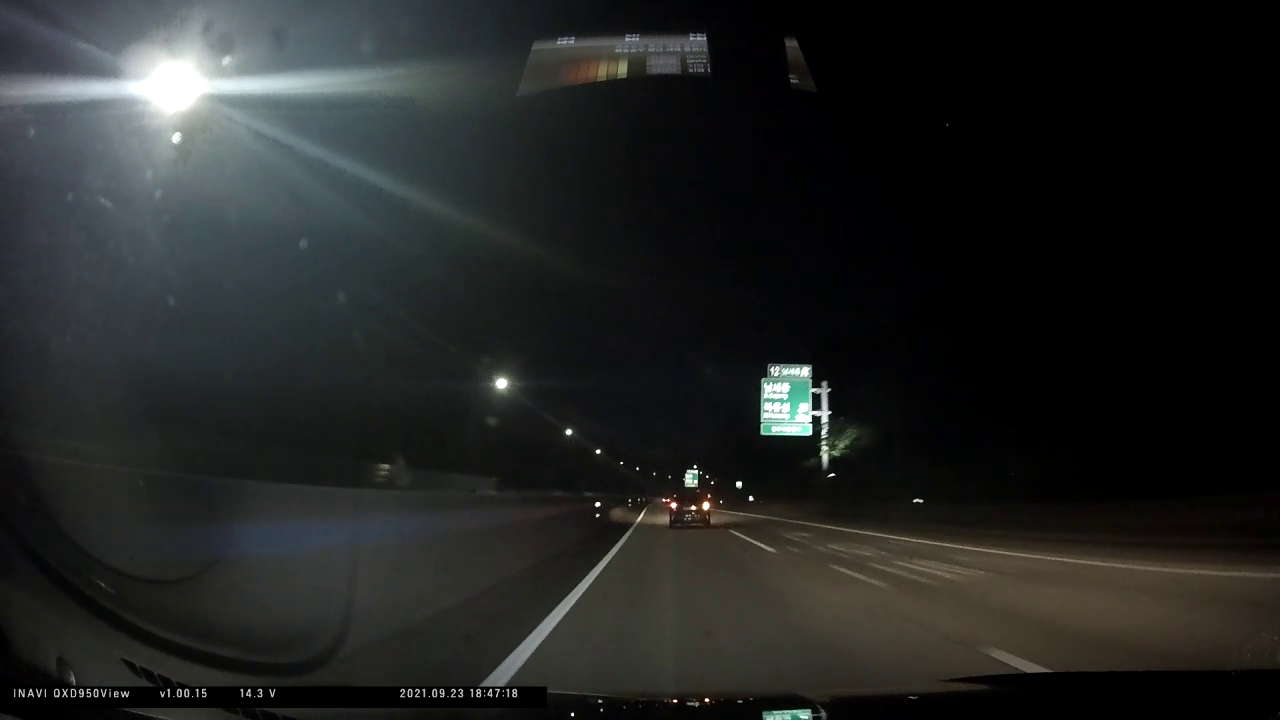

720 1280 3


In [4]:
file_name = '/gdrive/MyDrive/autonomous_data/black_box/ficture/error_picture_2.png'
frame = cv2.imread(file_name)
cv2_imshow(frame)
height, width, channel = frame.shape
print(height, width, channel)

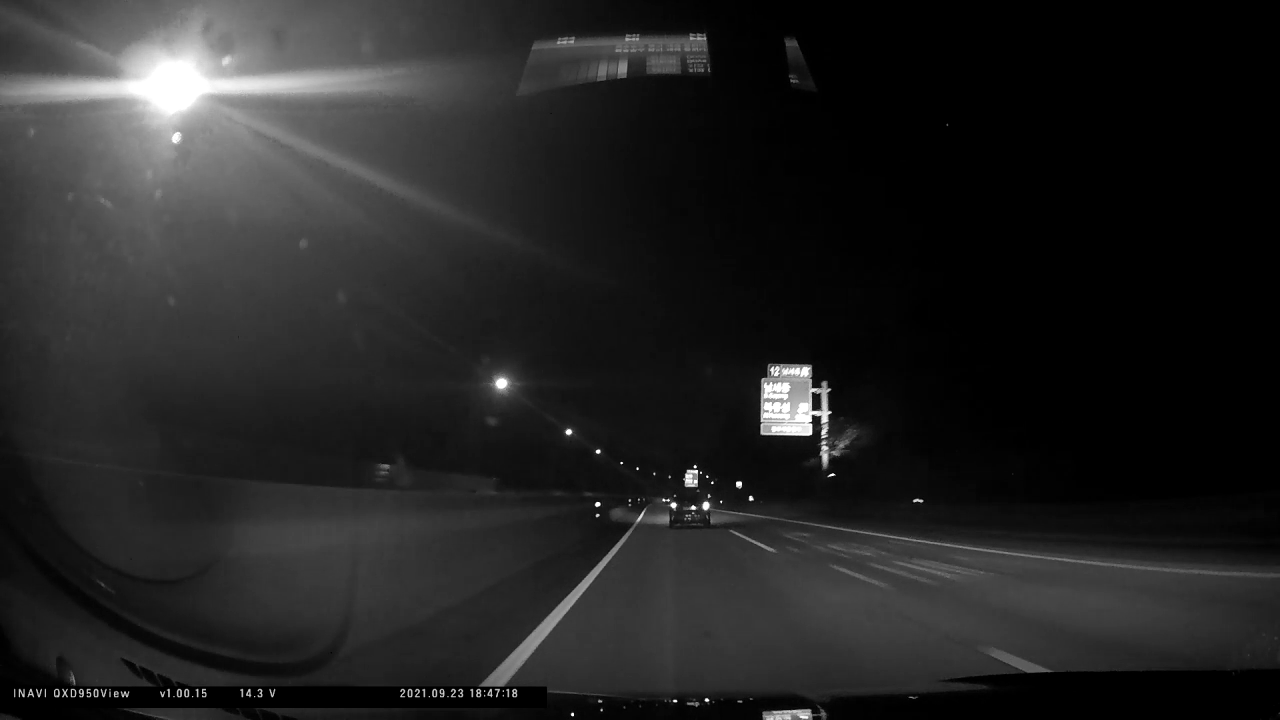

720 1280


In [5]:
#Convert the image to graysacle
gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
height, width = gray.shape
cv2_imshow(gray)
print(height, width)

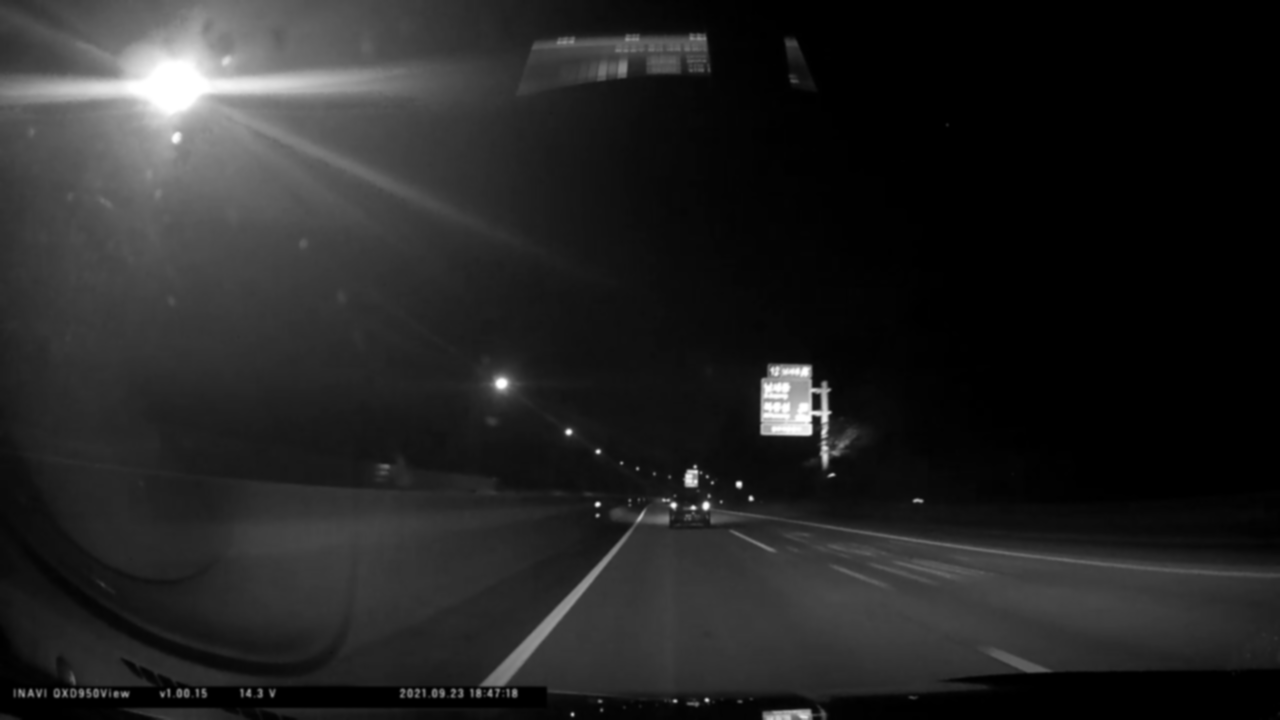

In [ ]:
# GaussianBlur for refucing noise
blur = cv2.GaussianBlur(gray, (5,5), 0)
cv2_imshow(blur)

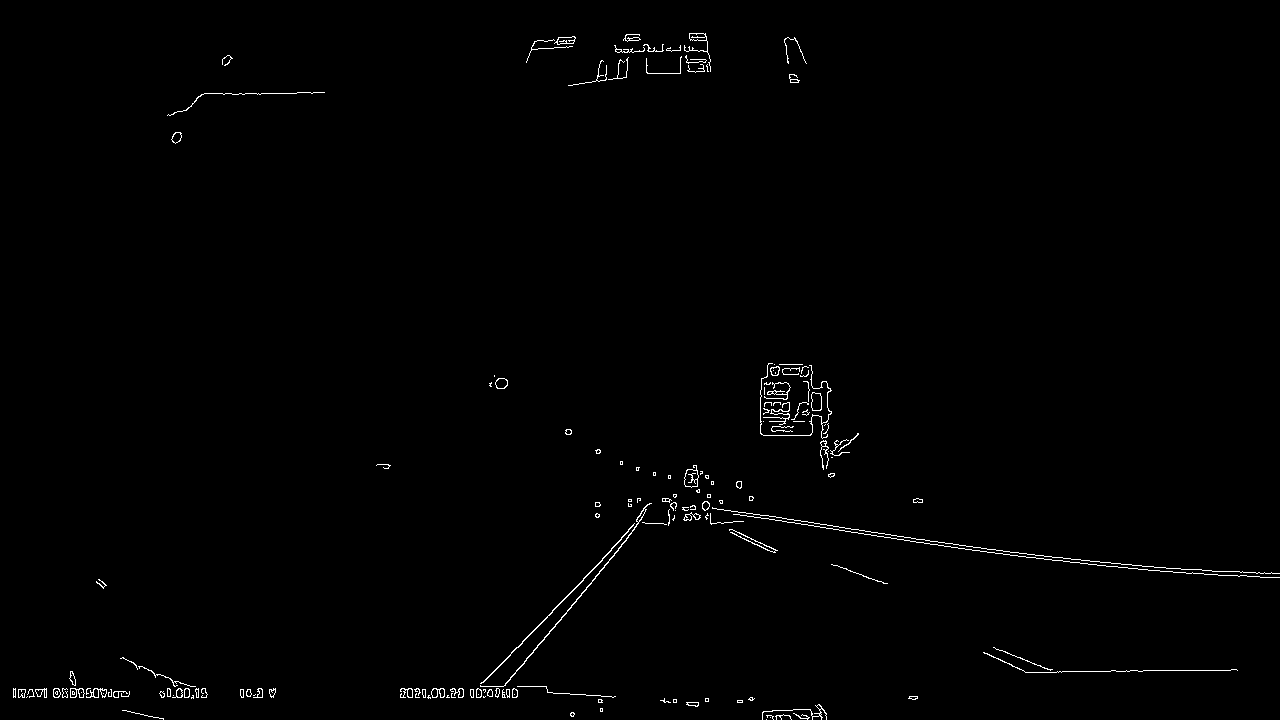

In [ ]:
canny = cv2.Canny(blur, 50, 130)
cv2_imshow(canny)

#2. Region of Interest

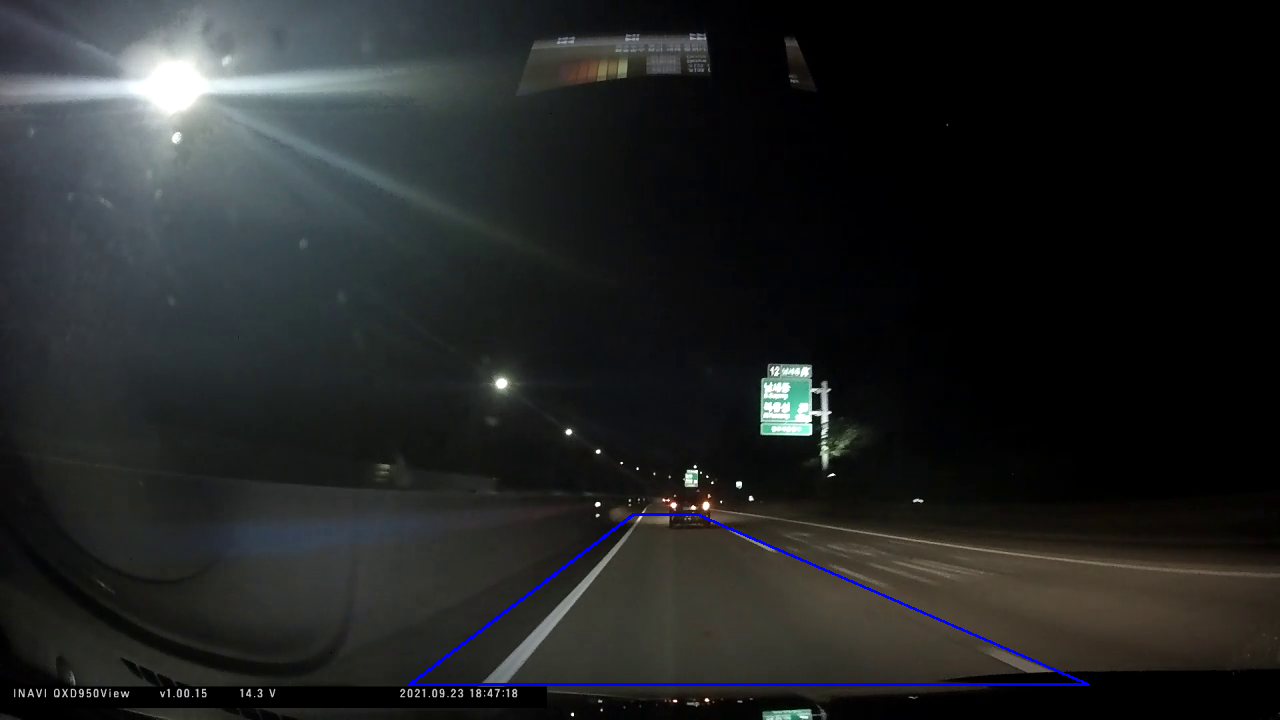

In [ ]:
frame = cv2.imread(file_name)
#poly_heigh = int(0.705 * height)
poly_heigh = int(0.715 * height)
poly_left = int(0.495 * width)
poly_right = int(0.545 * width)
poly_bottom = int(0.95 * height)
poly_right_bottom = int(0.85 * width)
poly_left_bottom = int(0.32 * width)
polygons = np.array([[(poly_left_bottom, poly_bottom), (poly_left, poly_heigh), (poly_right, poly_heigh), (poly_right_bottom, poly_bottom)]])
image = cv2.polylines(frame, [polygons], True, (255,0,0), 2)
cv2_imshow(image)

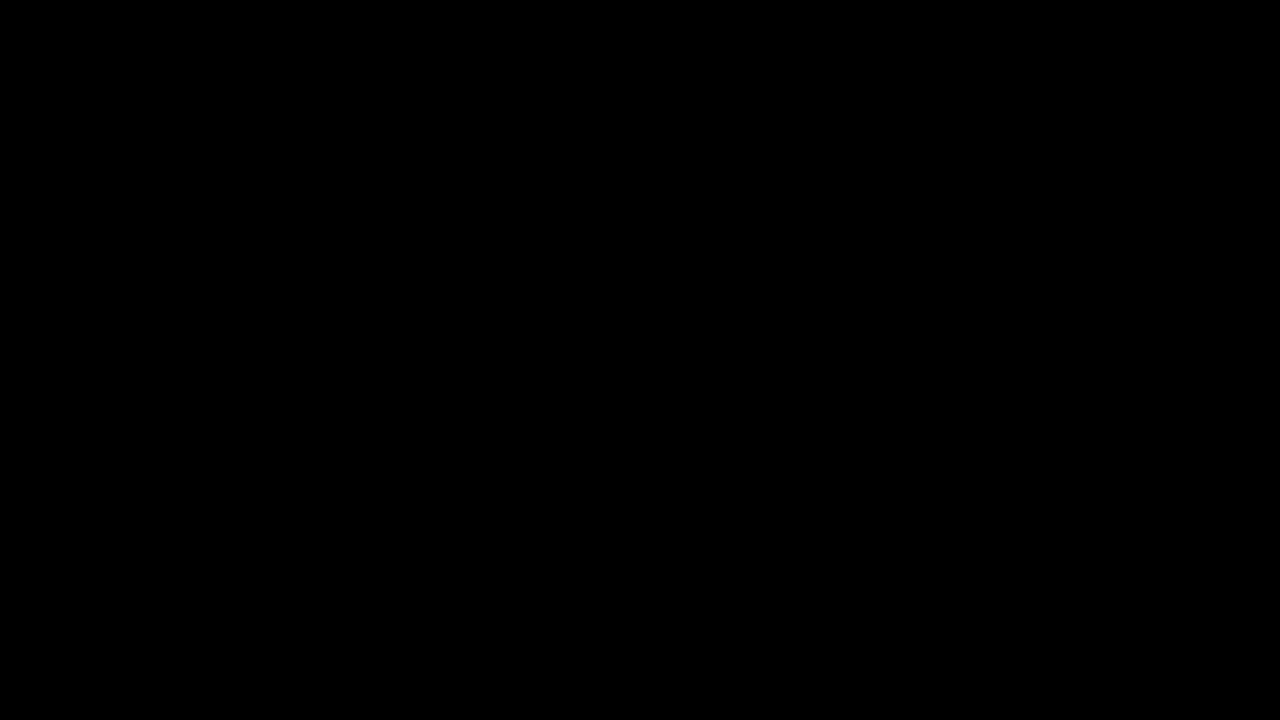

In [ ]:
mask = np.zeros((height, width), dtype='uint8')
cv2_imshow(mask)

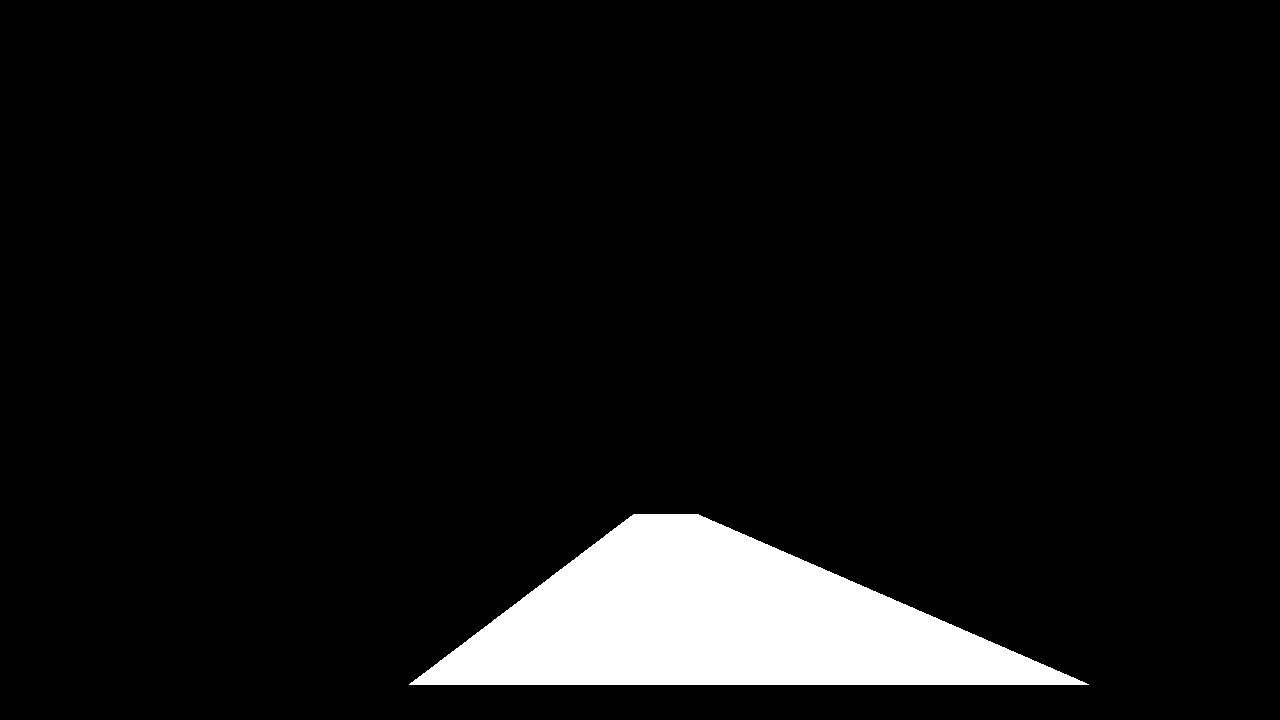

In [ ]:
out_mask = np.zeros((height, width), dtype='uint8')

poly_heigh = int(0.715 * height)
poly_left = int(0.495 * width)
poly_right = int(0.545 * width)
poly_bottom = int(0.95 * height)
poly_right_bottom = int(0.85 * width)
poly_left_bottom = int(0.32 * width)
polygons = np.array([[(poly_left_bottom, poly_bottom), (poly_left, poly_heigh), (poly_right, poly_heigh), (poly_right_bottom, poly_bottom)]])
cv2.fillPoly(out_mask, polygons, 255)
cv2_imshow(out_mask)

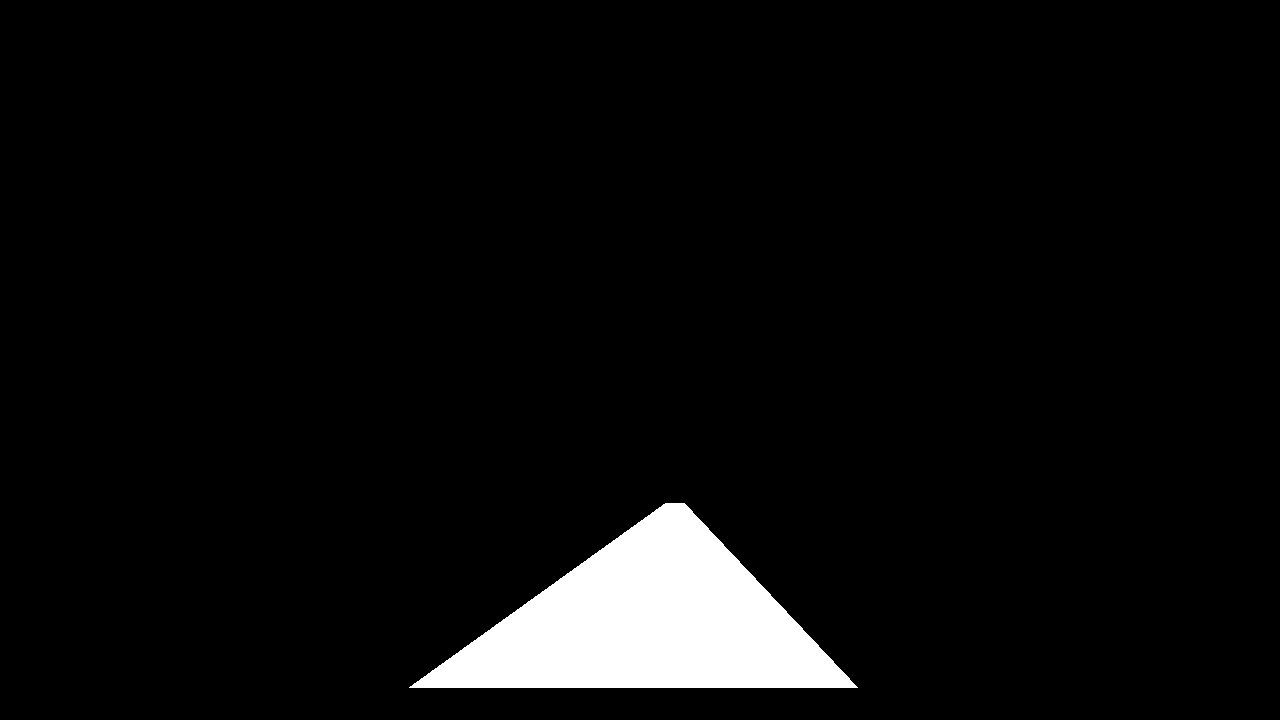

In [ ]:
in_mask = np.zeros((height, width), dtype='uint8')

poly_heigh = int(0.70 * height)
poly_left = int(0.52 * width)
poly_right = int(0.535 * width)
poly_bottom = int(0.955 * height)
poly_right_bottom = int(0.67 * width)
poly_left_bottom = int(0.32 * width)
polygons = np.array([[(poly_left_bottom, poly_bottom), (poly_left, poly_heigh), (poly_right, poly_heigh), (poly_right_bottom, poly_bottom)]])
cv2.fillPoly(in_mask, polygons, 255)
cv2_imshow(in_mask)

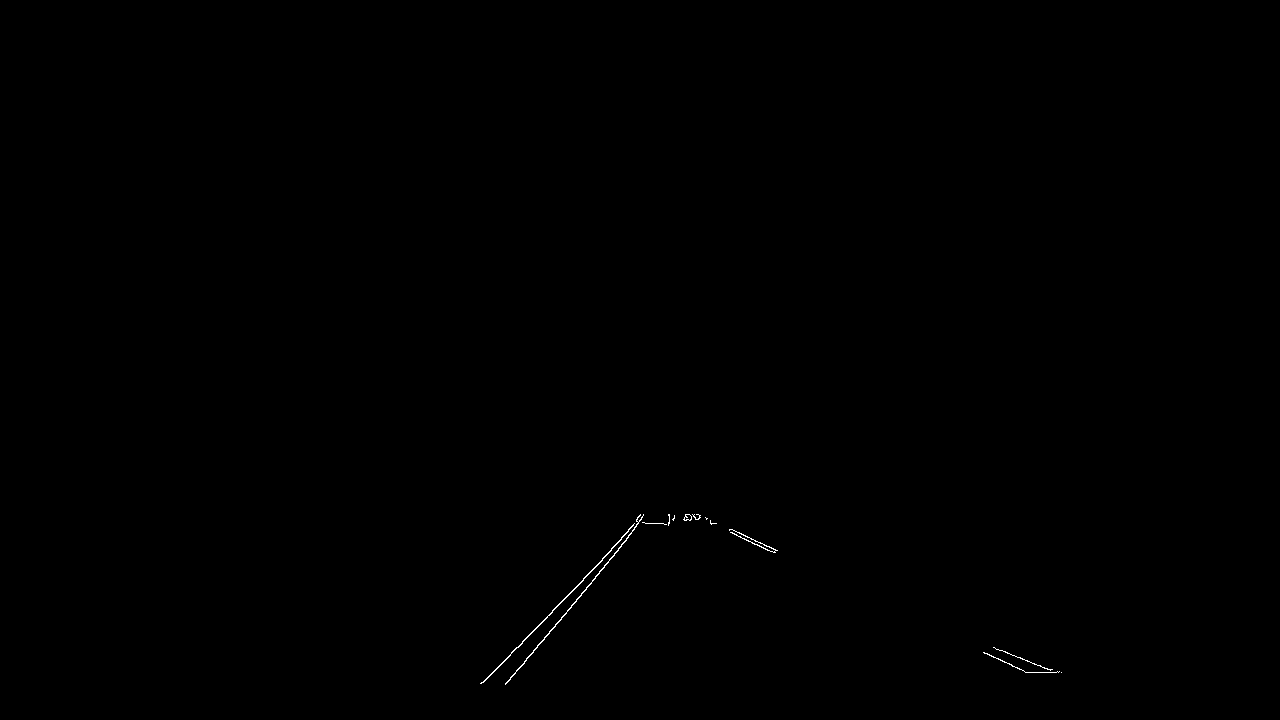

In [ ]:
# Bitwise operation between poly and mask
#line_masked = cv2.bitwise_xor(in_mask, out_mask)
masked = cv2.bitwise_and(canny, out_mask)
cv2_imshow(masked)

#3. Lane Detection

In [ ]:
lines = cv2.HoughLinesP(masked, 2, np.pi / 180, 20, np.array([]), 10, 50)

-1.193798449612403
-1.0377358490566038
0.4444444444444444
-1.1851851851851851
0.4117647058823529
0.4634146341463415
0.42857142857142855
0.4444444444444444
-0.14285714285714285
0.4166666666666667
-0.07142857142857142
-1.0526315789473684
-1.0
-0.3382352941176471
0.3225806451612903
0.0
-1.1403508771929824
-0.12698412698412698
-1.0377358490566038 0.4634146341463415


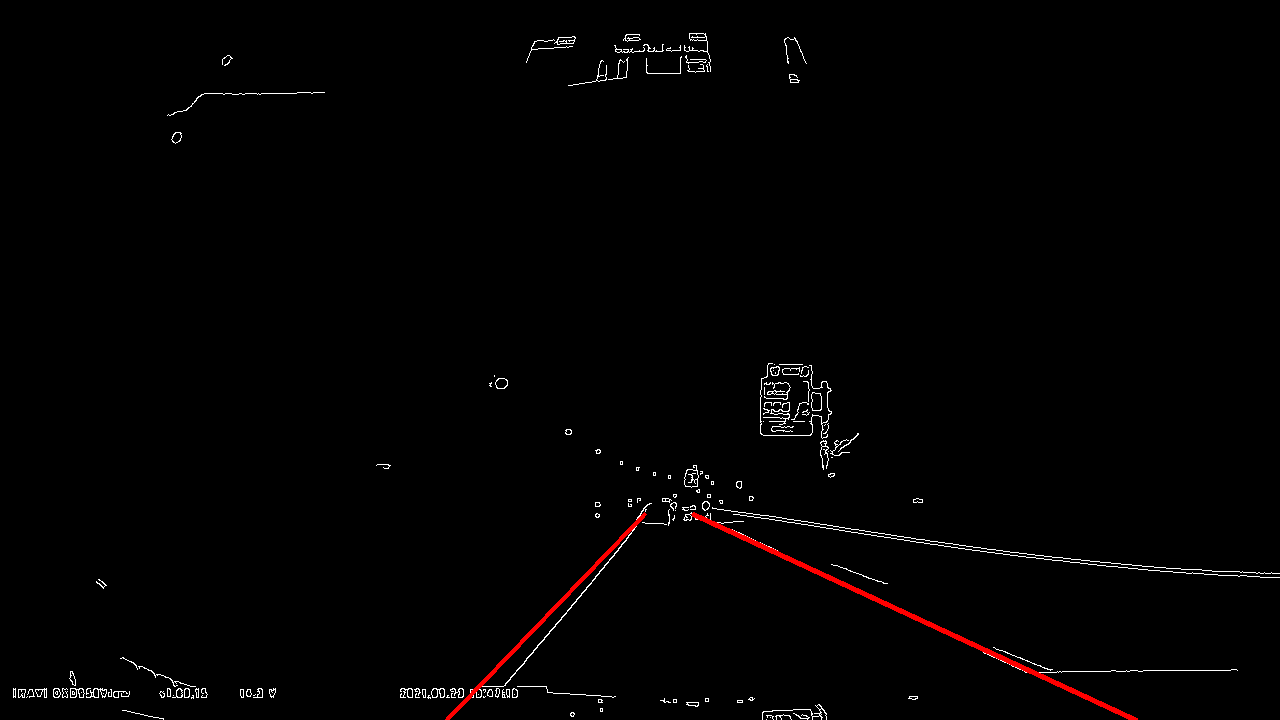

In [ ]:
image_rgb = cv2.cvtColor(canny, cv2.COLOR_GRAY2RGB)

longest_left_line_len = 0
longest_right_line_len = 0
longest_left_line = (0,0,0,0)
longest_right_line = (0,0,0,0)
long_left_line_m = 0
long_right_line_m = 0
long_left_intercept = 0
long_right_intercept = 0

if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)

        slope = ((y2-y1)/(x2-x1))
        line_length = math.sqrt((x1-x2)**2 + (y1-y2)**2)

        if slope > 0.45:
            if (line_length > longest_right_line_len):
                longest_right_line_len = line_length
                longest_right_line = (x1, y1, x2, y2)
                long_right_line_m = ((longest_right_line[1]-longest_right_line[3])/(longest_right_line[0]-longest_right_line[2]))
                long_right_intercept = longest_right_line[3]-(long_right_line_m * longest_right_line[2])

        elif slope < -0.45: 
            if (line_length > longest_left_line_len):
                longest_left_line_len = line_length
                longest_left_line = (x1, y1, x2, y2)
                long_left_line_m = ((longest_left_line[1]-longest_left_line[3])/(longest_left_line[0]-longest_left_line[2]))
                long_left_intercept = longest_left_line[3]-(long_left_line_m * longest_left_line[2])
        
        print(slope)
        #cv2.line(image_rgb, (x1,y1), (x2,y2), (0,0,255), 1)

print(long_left_line_m, long_right_line_m)

left_lane_bottom_xy = [0,0]
left_lane_top_xy = [0,0]
right_lane_bottom_xy = [0,0]
right_lane_top_xy = [0,0]

left_lane_bottom_xy[1] = height  # Y coordinate
left_lane_bottom_xy[0] = (left_lane_bottom_xy[1]-long_left_intercept)/long_left_line_m

left_lane_top_xy[1] = 0.715*height  # Y coordinate from ROI mask
left_lane_top_xy[0] = (left_lane_top_xy[1]-long_left_intercept)/long_left_line_m  # X 

right_lane_top_xy[1] = 0.715*height  # Y coordinate from ROI mask
right_lane_top_xy[0] = (right_lane_top_xy[1]-long_right_intercept)/long_right_line_m

right_lane_bottom_xy[1] = height  # Y coordinate
right_lane_bottom_xy[0] = (left_lane_bottom_xy[1]-long_right_intercept)/long_right_line_m

#cv2.line(image_rgb, (int(longest_left_line[0]), int(longest_left_line[1])), (int(longest_left_line[0]), int(longest_left_line[1])), (0,0,255), 5)
#cv2.line(image_rgb, (int(longest_right_line[0]), int(longest_right_line[1])), (int(longest_right_line[0]), int(longest_right_line[1])), (0,0,255), 5)

cv2.line(image_rgb, (int(left_lane_bottom_xy[0]), int(left_lane_bottom_xy[1])), (int(left_lane_top_xy[0]), int(left_lane_top_xy[1])), (0,0,255), 3)
cv2.line(image_rgb, (int(right_lane_bottom_xy[0]), int(right_lane_bottom_xy[1])), (int(right_lane_top_xy[0]), int(right_lane_top_xy[1])), (0,0,255), 3)

cv2_imshow(image_rgb)

0.5089820359281437
0.5523809523809524
-0.8405172413793104
-0.9330143540669856
0.5102040816326531
0.5294117647058824
0.11864406779661017
-0.1111111111111111
0.384
-1.2727272727272727
-0.85
0.5217391304347826
0.11206896551724138
-0.030303030303030304
0.0
-1.3111111111111111
-0.9333333333333333
0.5324675324675324
0.08196721311475409
0.4864864864864865
0.1875
0.5161290322580645
-0.1925925925925926
-0.84
-1.7105263157894737
-0.019417475728155338
0.5529953917050692
0.5396825396825397
-0.8367346938775511
0.1885245901639344
-0.8947368421052632
-0.21621621621621623
1.0
0.4642857142857143
-0.46511627906976744
-0.2872340425531915
-0.32
-1.0740740740740742
0.020833333333333332
-0.839622641509434
0.12173913043478261
0.0
-7.75
-0.06451612903225806
0.0
-1.0
0.07079646017699115
-0.839622641509434 0.4642857142857143


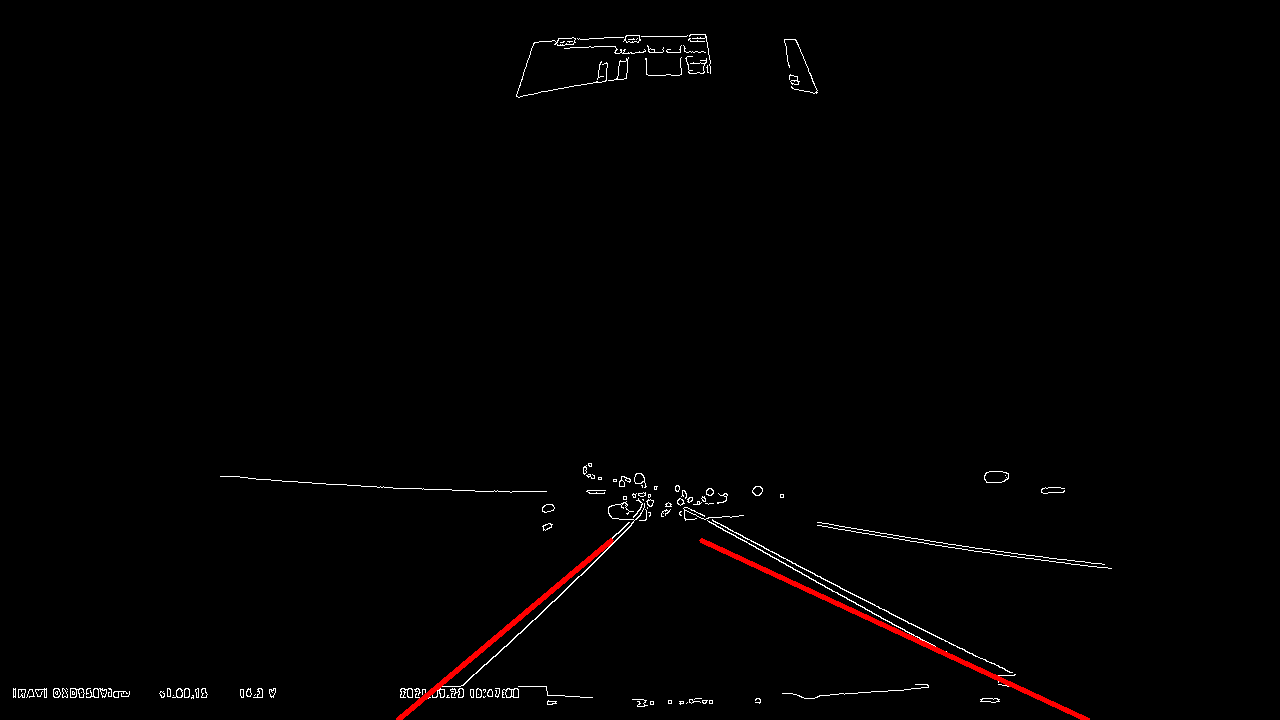

In [ ]:
image_rgb = cv2.cvtColor(canny, cv2.COLOR_GRAY2RGB)

longest_left_line_len = 0
longest_right_line_len = 0
longest_left_line = (0,0,0,0)
longest_right_line = (0,0,0,0)
long_left_line_m = 0
long_right_line_m = 0
long_left_intercept = 0
long_right_intercept = 0

if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        slope = ((y2-y1)/(x2-x1))

        if (0.85 > slope > 0.45):
            if (line_length > longest_right_line_len):
                longest_right_line = (x1, y1, x2, y2)
                long_right_line_m = ((y1-y2)/(x1-x2))
                long_right_intercept = y2 - (long_right_line_m * x2)

        elif -0.85 < slope < -0.45: 
            if (line_length > longest_left_line_len):
                longest_left_line = (x1, y1, x2, y2)
                long_left_line_m = ((y1-y2)/(x1-x2))
                long_left_intercept = y2 - (long_left_line_m * x2)

        #cv2.line(image_rgb, (x1,y1), (x2,y2), (0,0,255), 1)

print(long_left_line_m, long_right_line_m)

left_lane_bottom_xy = [0,0]
left_lane_top_xy = [0,0]
right_lane_bottom_xy = [0,0]
right_lane_top_xy = [0,0]

left_lane_bottom_xy[1] = height  # Y coordinate
left_lane_bottom_xy[0] = (left_lane_bottom_xy[1]-long_left_intercept)/long_left_line_m

left_lane_top_xy[1] = 0.75*height  # Y coordinate from ROI mask
left_lane_top_xy[0] = (left_lane_top_xy[1]-long_left_intercept)/long_left_line_m  # X 

right_lane_top_xy[1] = 0.75*height  # Y coordinate from ROI mask
right_lane_top_xy[0] = (right_lane_top_xy[1]-long_right_intercept)/long_right_line_m

right_lane_bottom_xy[1] = height  # Y coordinate
right_lane_bottom_xy[0] = (left_lane_bottom_xy[1]-long_right_intercept)/long_right_line_m

#cv2.line(image_rgb, (int(longest_left_line[0]), int(longest_left_line[1])), (int(longest_left_line[0]), int(longest_left_line[1])), (0,0,255), 5)
#cv2.line(image_rgb, (int(longest_right_line[0]), int(longest_right_line[1])), (int(longest_right_line[0]), int(longest_right_line[1])), (0,0,255), 5)

cv2.line(image_rgb, (int(left_lane_bottom_xy[0]), int(left_lane_bottom_xy[1])), (int(left_lane_top_xy[0]), int(left_lane_top_xy[1])), (0,0,255), 3)
cv2.line(image_rgb, (int(right_lane_bottom_xy[0]), int(right_lane_bottom_xy[1])), (int(right_lane_top_xy[0]), int(right_lane_top_xy[1])), (0,0,255), 3)

cv2_imshow(image_rgb)

In [ ]:
frame = cv2.imread(file_name)

longest_left_line_len = 0
longest_right_line_len = 0
longest_left_line = (0,0,0,0)
longest_right_line = (0,0,0,0)
long_left_line_m = 0
long_right_line_m = 0
long_left_intercept = 0
long_right_intercept = 0

if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)

        slope = ((y2-y1)/(x2-x1))
        line_length = math.sqrt((x1-x2)**2 + (y1-y2)**2)

        if (0.8 > slope > 0.5):
            if (line_length > longest_right_line_len):
                longest_right_line = (x1, y1, x2, y2)
                long_right_line_m = ((longest_right_line[1]-longest_right_line[3])/(longest_right_line[0]-longest_right_line[2]))
                long_right_intercept = longest_right_line[3]-(long_right_line_m * longest_right_line[2])

        elif -0.8 < slope < -0.5: 
                if (line_length > longest_left_line_len):
                    longest_left_line = (x1, y1, x2, y2)
                    long_left_line_m = ((longest_left_line[1]-longest_left_line[3])/(longest_left_line[0]-longest_left_line[2]))
                    long_left_intercept = longest_left_line[3]-(long_left_line_m * longest_left_line[2])
        #cv2.line(image_rgb, (x1,y1), (x2,y2), (0,0,255), 1)

left_lane_bottom_xy = [0,0]
left_lane_top_xy = [0,0]
right_lane_bottom_xy = [0,0]
right_lane_top_xy = [0,0]

left_lane_bottom_xy[1] = height  # Y coordinate
left_lane_bottom_xy[0] = (left_lane_bottom_xy[1]-long_left_intercept)/long_left_line_m

left_lane_top_xy[1] = 0.715*height  # Y coordinate from ROI mask
left_lane_top_xy[0] = (left_lane_top_xy[1]-long_left_intercept)/long_left_line_m  # X 

right_lane_top_xy[1] = 0.715*height  # Y coordinate from ROI mask
right_lane_top_xy[0] = (right_lane_top_xy[1]-long_right_intercept)/long_right_line_m

right_lane_bottom_xy[1] = height  # Y coordinate
right_lane_bottom_xy[0] = (left_lane_bottom_xy[1]-long_right_intercept)/long_right_line_m

cv2.line(frame, (int(left_lane_bottom_xy[0]), int(left_lane_bottom_xy[1])), (int(left_lane_top_xy[0]), int(left_lane_top_xy[1])), (0,0,255), 3)
cv2.line(frame, (int(right_lane_bottom_xy[0]), int(right_lane_bottom_xy[1])), (int(right_lane_top_xy[0]), int(right_lane_top_xy[1])), (0,0,255), 3)

cv2_imshow(frame)

Output hidden; open in https://colab.research.google.com to view.